# Homework 8: Shifted pictures
by Rustam Guseyn-zade ([link canvas](https://skoltech.instructure.com/courses/3546/users/9673))

## Table of contents
* [MPI shifted pictures](#MPI-shifted-pictures)
* [Speedup vs Number of processors](#Speedup-vs-Number-of-processors)
* [Memory consumption vs Number of processors](#Memory-consumption-vs-Number-of-processors)

In [1]:
#import needed libraries
import cv2
import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import os
from PIL import Image
import random
import time
import tracemalloc

## MPI shifted pictures

### Written in non-mpi

In [2]:
img = cv2.imread('minecraft.jpg')
height = img.shape[0]

image = img.copy()
number_of_splits = 4
split = np.array_split(image, number_of_splits, axis=0)
new_split = split.copy()

for roll in range(height):
    for i in range(len(split)):
        new_split[i] = np.roll(split[i], 1, axis=0)
    buffer = new_split[0][0]
    for i in range(1, len(split)):
        new_buf = new_split[i][0].copy()
        new_split[i] = new_split[i]
        new_split[i][0] = buffer
        buffer = new_buf
    new_split[0][0] = buffer
    cv2.imwrite('sminecraft' + '{0:05}'.format(roll) + '.jpg', np.concatenate(new_split))
    split = new_split
    print("[%-50s] %d%%" % ('='* int(roll * 50 / (height-1)) , int(roll * 100 / (height-1))), end='\r')

fp_in = "sminecraft*.jpg"
fp_out = "shifted_minecraft.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=30, loop=0)
    
for filePath in sorted(glob.glob(fp_in)):
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)
print(f"shifted pictures gif could be found in file {fp_out}")

shifted pictures gif could be found in file shifted_minecraft.gif


### Written in mpi

In [3]:
%%writefile shifted.py
# Create file shifted.py
import cv2
import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from mpi4py import MPI
import os
from PIL import Image
import random

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

img = cv2.imread('minecraft.jpg')
height = img.shape[0]

for roll in range(height):
    if rank == 0 and roll == 0:
        img = cv2.imread('minecraft.jpg')
        image = img.copy()
        split = np.array_split(image, size, axis=0)
    if rank != 0:
        split = None

    split_part = comm.scatter(split, root=0)
    split_part = np.roll(split_part, 1, axis=0)
    
    if size != 1:
        it_to_send = rank+1 if rank != size-1 else 0
        it_to_recv = rank-1 if rank != 0 else size-1
        comm.send(split_part[0], dest=it_to_send)
        split_part_first = comm.recv(source=it_to_recv)
        split_part[0] = split_part_first
    
    new_split = comm.gather(split_part,root=0)
    
    if rank == 0:
        print("[%-50s] %d%%" % ('='* int(roll * 50 / (height-1)) , int(roll * 100 / (height-1))), end='\r')
        cv2.imwrite('sminecraft' + '{0:05}'.format(roll) + '.jpg', np.concatenate(new_split))
        split = new_split.copy()

if rank == 0:
    fp_in = "sminecraft*.jpg"
    fp_out = "shifted_minecraft.gif"

    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=30, loop=0)
    
    for filePath in sorted(glob.glob(fp_in)):
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)
    print(f"shifted pictures gif could be found in file {fp_out}")

Overwriting shifted.py


In [4]:
!mpirun --allow-run-as-root -np 2 python3 shifted.py

shifted pictures gif could be found in file shifted_minecraft.gif


file `shifted_minefraft.gif` was too big, so I compressed it via `zip` command. But also it would be easier to run locally script, it takes below 1 minute to execute

## Speedup vs Number of processors

Text(0.5, 1.0, 'Shifted pictures speedup')

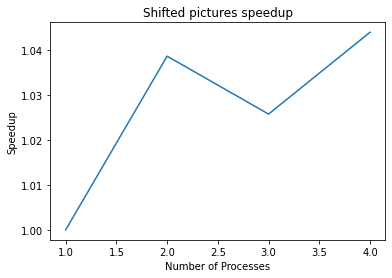

In [5]:
def measure_n_processes_time(processes_number, attempts=3):
    number_processes_time = []
    for i in range(attempts):
        start = time.time()
        !mpirun --allow-run-as-root -n {processes_number} python3 shifted.py >/dev/null 2>&1
        end = time.time()
        number_processes_time.append(end - start)
        print(f'measure attempt {i+1} from {attempts} for {processes_number} processes', end='\r')
    return sum(number_processes_time) / attempts

processes_times = [measure_n_processes_time(i) for i in range(1,5)]
speedups = [processes_times[0] / processes_times[i] for i in range(len(processes_times))]
plt.plot(range(1, 5), speedups)
plt.ylabel('Speedup')
plt.xlabel('Number of Processes')
plt.title('Shifted pictures speedup')

## Memory consumption vs Number of processors

Text(0.5, 1.0, 'Shifted pictures memory consumption')

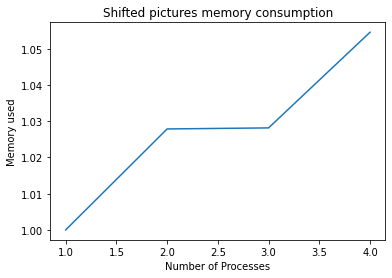

In [6]:
def measure_n_processes_memory(processes_number, attempts=3):
    number_processes_memory = []
    for i in range(attempts):
        tracemalloc.start()
        !mpirun --allow-run-as-root -n {processes_number} python3 shifted.py >/dev/null 2>&1
        number_processes_memory.append(tracemalloc.get_traced_memory()[1])
        tracemalloc.stop()
        print(f'measure attempt {i+1} from {attempts} for {processes_number} processes', end='\r')
    return sum(number_processes_memory) / attempts

processes_memories = [measure_n_processes_memory(i) for i in range(1,5)]
memories = [processes_memories[0] / processes_memories[i] for i in range(len(processes_memories))]
plt.plot(range(1, 5), memories)
plt.ylabel('Memory used')
plt.xlabel('Number of Processes')
plt.title('Shifted pictures memory consumption')